# **Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import joblib

In [21]:
random_state = 1000
df = pd.read_csv("SpotifyDataLarge.csv")
data_size = 10000 # Change this to adjust the dataset partition size

# **Preprocessing**

In [22]:
df.isna().sum()  # Checking for null values
df = df.dropna()

In [ ]:
#df.info() # Checking value types. Everything is int or float.

In [23]:
df.drop('isrc', axis=1, inplace=True)
df.drop('updated_on', axis=1, inplace=True)

**Plotting the correlation map**

In [ ]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = df.corr()
sns.heatmap(corr,annot=True, cmap="YlGnBu")

**Creating and scaling datasets**

In [24]:
scale = StandardScaler()
df_sc = scale.fit_transform(df)
df_sc = pd.DataFrame(df_sc, columns=df.columns)

In [6]:
y = df_sc['danceability'] # The aim is to predict the danceability of a song.
X = df_sc.drop('danceability', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X[:data_size], y[:data_size], test_size=0.4, random_state=random_state) # Splitting as 60% train test, 40% test set.

# **Regression with SVR**

In [ ]:
SVM_regression = SVR(C=10, kernel='linear')
SVM_regression.fit(X_train, y_train) # training the model.

In [ ]:
y_pred = SVM_regression.predict(X_test) # Predicting values

In [ ]:
predictions = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred}) # Creating a dataframe with real values and predictions side by side
# predictions.head()

**Evaluating the model**

In [ ]:
MSE_test = round(np.mean(np.square(y_test- y_pred)),2)
RMSE_test = round(np.sqrt(MSE_test),2)
print(RMSE_test, SVM_regression.score(X_test, y_test))

Results were: 1000 samples: 0.66
17k 0.64
Therefore with the increasing amount of samples, the mean squared error is decreasing

# **Finding optimal model with Grid Search**

In [ ]:
param_grid = {'C': [1,10,100], 'gamma': [1,0.1,0.01], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear'], 'degree' : [3,5,9]}

In [ ]:
grid = GridSearchCV(estimator=SVR(),param_grid= param_grid, refit = True, verbose=3, cv=2)

In [ ]:
grid.fit(X_train,y_train)

In [ ]:
grid.best_params_

{'C': 1, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'}

In [ ]:
grid.best_estimator_.score(X_train, y_train)

In [ ]:
y_pred_best = grid.predict(X_test)

In [ ]:
predictions['y_pred_best'] = y_pred_best # Adding best predictions to the dataframe of previous predictions
predictions.head()

# **Optimal Model**

In [7]:
optimal = SVR(C=1, gamma = 0.1, kernel = 'rbf')

In [8]:
optimal.fit(X_train, y_train)

SVR(C=1, gamma=0.1)

In [9]:
y_optimal = optimal.predict(X_test)

In [10]:
MSE_opt = round(np.mean(np.square(y_test - y_optimal)),4)
print(MSE_opt, optimal.score(X_test, y_test))

0.4488 0.47600628858836336


# **Dimensionality Reduction via Feature Selection**


In [26]:
y_pruned = df_sc['danceability']
#df_sc_pruned = df_sc.drop('danceability', axis=1)
#df_sc_pruned  = df_sc_pruned .drop('tempo', axis=1)
#df_sc_pruned  = df_sc_pruned .drop('key', axis=1)
X_pruned = df_sc.drop(['mode', 'key', 'tempo'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_pruned[:data_size], y_pruned[:data_size], test_size=0.4, random_state=random_state) # Splitting as 60% train test, 40% test set.

In [27]:
optimal.fit(X_train, y_train)

SVR(C=1, gamma=0.1)

In [28]:
y_optimal = optimal.predict(X_test)

In [29]:
MSE_opt = round(np.mean(np.square(y_test - y_optimal)),4)
MSE_opt

0.0111

In [30]:
optimal.score(X_test, y_test)

0.9840698942284901

In [31]:
predictions = pd.DataFrame({'y_test':y_test, 'y_pred':y_optimal})

In [32]:
predictions.head()

,y_test,y_pred
8034,0.740728,0.721118
7122,0.690633,0.783631
7571,-0.211068,-0.151020
7347,0.790823,0.855026
3246,-0.430232,-0.388354


**Saving the optimal model**

In [ ]:
joblib.dump(optimal, 'SpotifySVR.joblib') # To load the trained model simply use joblib.load('SpotiftSVR.joblib')

['SpotifySVR.joblib']

# Plotting learning curve

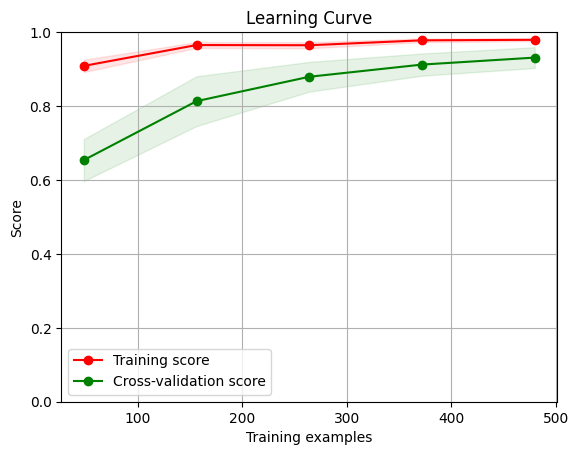

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, ylim, cv, n_jobs):#, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs)#, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

negative_infinity =  float('-inf')
plot_learning_curve(optimal, X_train, y_train, ylim=(0, 1), cv=5, n_jobs=-1)
plt.show()

# **Comparing with KNN-Regressor**

In [ ]:
KNN = KNeighborsRegressor()

In [ ]:
X_train.shape

(240000, 10)

In [ ]:
KNN.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [ ]:
y_knn = KNN.predict(X_test)

In [ ]:
MSE_opt = round(np.mean(np.square(y_test - y_knn)),2)
RMSE_opt = round(np.sqrt(MSE_opt),2)
RMSE_opt

0.14

In [ ]:
KNN.score(X_test, y_test)

0.9845796739201264